In [1]:
import numpy as np
import os
from ECG.eager_ops import expected_gradients as eg
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
path = "./eval_data_10k/"

In [3]:
os.listdir(path)

['cnn_ph',
 'cnn_ph_eg',
 'cnn_pl',
 'cnn_pl_eg',
 'lstm_ph',
 'lstm_ph_eg',
 'lstm_pl',
 'lstm_pl_eg',
 'svc_ph',
 'svc_pl',
 'teset_x.npy',
 'teset_y.npy']

In [48]:
# Creating the confusion matrices for PH
# cnn_ph_cv1 = np.load(path+ph_folders[0]+"/cms_cv1.npy")

In [28]:
def get_cmss(foldername, tname):
    if tname == "ph":
        cmss = []
        for i in range(1,11):
            cmss.append(np.load(path+foldername+"/cms_cv"+str(i)+".npy").reshape(1,8,8))
        cmss = np.concatenate(tuple(cmss), axis=0)
        return cmss
    elif tname == "pl":
        return np.load(path+foldername+"/cms.npy")

def get_results(foldername, tname):
    if tname == "ph":
        results = []
        for i in range(1,11):
            results.append(np.load(path+foldername+"/results_cv"+str(i)+".npy", allow_pickle=True)[1:6])
        return np.stack(tuple(results))
    elif tname == "pl":
        return np.load(path+foldername+"/results.npy", allow_pickle=True)[0][1:6]


In [11]:
def make_cm(cmss, name, fname):
    categories=['N','L','R','V','A','F','f','/']
    plt.figure(figsize=(10,7), dpi=300)
    sns.heatmap(cmss.mean(axis=0), annot=True, xticklabels=categories, yticklabels=categories)
    plt.title(name)
    plt.savefig("./images/"+fname,dpi=300)
    plt.show()

### Generating Confusion Matrices

In [14]:
# a = get_cmss("cnn_ph", "ph") done!
# b = get_cmss("lstm_ph", "ph") done!
# c = get_cmss('cnn_ph_eg', "ph") done!
# d = get_cmss('lstm_ph_eg', "ph")
# s = get_cmss('svc_ph', "ph") done!
# make_cm(a, "CNN - Beat holdout Confusion Matrix", "cnn_ph") done!
# make_cm(b, "LSTM - Beat holdout Confusion Matrix", "lstm_ph") done!
# make_cm(c, "CNN - Beat holdout with ECG Confusion Matrix", "cnn_ph_eg") done!
# make_cm(d, "LSTM - Beat holdout with ECG Confusion Matrix",'lstm_ph_eg')
# make_cm(s, "SVC - Beat holdout Confusion Matrix", "svc_ph") done!

In [16]:
# e = get_cmss("cnn_pl", "pl")
# f = get_cmss("lstm_pl", "pl")
# g = get_cmss('cnn_pl_eg', "pl")
# h = get_cmss('lstm_pl_eg', "pl")
# t = get_cmss('svc_pl', "pl")
# make_cm(e, "CNN - Patient leaveout Confusion Matrix", "cnn_pl")
# make_cm(f, "LSTM - Patient leaveout Confusion Matrix", "lstm_pl")
# make_cm(g, "CNN - Patient leaveout with ECG Confusion Matrix", 'cnn_pl_eg')
# make_cm(h, "LSTM - Patient leaveout with ECG Confusion Matrix", 'lstm_pl_eg')
# make_cm(t, "SVC - Patient leaveout Confusion Matrix", "svc_pl")

In [52]:
d_r = get_results("cnn_pl", "pl")
e_r = get_results("lstm_pl", "pl")
f_r = get_results('cnn_pl_eg', "pl")
g_r = get_results('lstm_pl_eg', "pl")
print(d_r[3][1:6])
print(f_r[0][1:6])
print(e_r[0][1:6])
print(g_r[0][1:6])

[0.828 0.413 0.484 0.434 0.828]
[0.81 0.446 0.472 0.428 0.81]
[0.631 0.381 0.337 0.294 0.631]
[0.655 0.386 0.309 0.279 0.655]


In [53]:
def cal_eg(m, dx, dy): 
  test_d = tf.data.Dataset.from_tensor_slices((dx,dy))
  test_d = test_d.batch(200)
  att = None
  for i, (x_batch, y_batch) in enumerate(test_d):
    if i==0:
        att = eg(inputs=x_batch, labels=y_batch, model=m)
    else:
        att = np.append(att,eg(inputs=x_batch, labels=y_batch, model=m),axis=0)
  return att

def eg_att(foldername, tname):
    if tname=="ph":
        test_y = np.load("./eval_data_10k/teset_y.npy", allow_pickle=True)
        test_x = np.load("./eval_data_10k/teset_x.npy", allow_pickle=True)
        attributions = []
        for i in range(1,11):
            m = tf.keras.models.load_model(path+foldername+"/Model_cv"+str(i)+".h5")
            dx = test_x[i-1].reshape(-1, test_x[i-1].shape[1], 1).astype(np.float32)
            dy = tf.keras.utils.to_categorical(test_y[i-1].astype(np.float32))
            attributions.append(cal_eg(m, dx, dy))
        return attributions
    elif tname=="pl":
        test_c0 = np.genfromtxt('./Data/test_patients_fc.csv', delimiter=',')
        test_c1 = np.genfromtxt('./Data/test_patients_sc.csv', delimiter=',')
        test_x_c01 = np.concatenate((test_c0[:, :-2], test_c1[:, :-2]), axis=1)
        test_y_c01 = np.concatenate((test_c0[:, -2:], test_c0[:, -2:]), axis=1)
        dx = test_x_c01.reshape(-1, test_x_c01.shape[1], 1).astype('float32')
        dy = tf.keras.utils.to_categorical(test_y_c01[:,0])
        m = tf.keras.models.load_model(path+foldername+"/Model0.h5")
        return cal_eg(m, dx, dy)

In [ ]:
# test_c0 = np.genfromtxt('./Data/test_patients_fc.csv', delimiter=',')
# test_c1 = np.genfromtxt('./Data/test_patients_sc.csv', delimiter=',')
# test_x_c01 = np.concatenate((test_c0[:, :-2], test_c1[:, :-2]), axis=1)
# test_y_c01 = np.concatenate((test_c0[:, -2:], test_c0[:, -2:]), axis=1)
# dx = test_x_c01.reshape(-1, test_x_c01.shape[1], 1).astype('float32')
# dy = tf.keras.utils.to_categorical(test_y_c01[:,0])
# print(dy.shape, dx.shape)

(9902, 9) (9902, 920, 1)


In [ ]:
# m = tf.keras.models.load_model(path+"cnn_pl"+"/Model0.h5")
# cal_eg(m, dx, dy).shape

(9902, 920, 1)

In [69]:
# EG graphs
att= np.load("./eg_attributions/lstm_pl_eg.npy")
test_c0 = np.genfromtxt('./Data/test_patients_fc.csv', delimiter=',')
test_c1 = np.genfromtxt('./Data/test_patients_sc.csv', delimiter=',')
test_x_c01 = np.concatenate((test_c0[:, :-2], test_c1[:, :-2]), axis=1)
test_y_c01 = np.concatenate((test_c0[:, -2:], test_c0[:, -2:]), axis=1)
dx = test_x_c01.reshape(-1, test_x_c01.shape[1], 1).astype('float32')
dy = tf.keras.utils.to_categorical(test_y_c01[:,0])


## Function to plot attribution maps

In [63]:
def normalise_att(att):
    return (att-np.min(att))/(np.max(att)-np.min(att))

In [223]:
def get_att_maps(foldername, tname, class_l, title):
    categories=['N','L','R','V','A','F','PN','P']
    if tname=="ph":
        # Loading data
        test_y = np.load("./eval_data_10k/teset_y.npy", allow_pickle=True)
        test_x = np.load("./eval_data_10k/teset_x.npy", allow_pickle=True)
        atts = []
        for i in range(1,11):
            atts.append(np.array([normalise_att(i) for i in np.load("./eg_attributions/"+foldername+"/att"+str(i)+".npy").squeeze()]))
        indexes_for_class = [np.where(i==class_l) for i in test_y]
        # class atts for each cv
        atts_for_class = [atts[i][indexes_for_class[i][0]] for i in range(len(indexes_for_class))]
        # mean atts for every cv
        mean_atts_each_cv = np.array([np.mean(i, axis=0) for i in atts_for_class])
        # mean atts of all cvs
        mean_cv_atts = mean_atts_each_cv.mean(axis=0)
        # getting signals for each cv
        beats_for_class = [test_x[i][indexes_for_class[i][0]].squeeze() for i in range(len(indexes_for_class))]
        # mean beat for every cv
        mean_beats_each_cv = np.array([np.mean(i, axis=0) for i in beats_for_class])
        # mean beat of all cvs
        mean_cv_beat = mean_beats_each_cv.mean(axis=0)
        
        plt.figure(figsize=(14,4), dpi=300)
        plt.plot(mean_cv_beat)
        plt.title(title)
        plt.scatter(np.arange(len(mean_cv_beat)), mean_cv_beat, cmap='inferno_r', c=mean_cv_atts, s=50)
        clim= np.ravel(mean_cv_atts)
        plt.clim(min(clim),max(clim))
        plt.colorbar()
        plt.savefig("./images/attributions/"+foldername+"/"+categories[class_l-1],dpi=300)
        # print("./images/attributions/"+foldername+"/"+categories[class_l-1])
        plt.show()
    elif tname=="pl":
        # Loading data
        test_c0 = np.genfromtxt('./Data/test_patients_fc.csv', delimiter=',')
        test_c1 = np.genfromtxt('./Data/test_patients_sc.csv', delimiter=',')
        test_x_c01 = np.concatenate((test_c0[:, :-2], test_c1[:, :-2]), axis=1)
        test_y_c01 = np.concatenate((test_c0[:, -2:], test_c0[:, -2:]), axis=1)
        dx = test_x_c01.reshape(-1, test_x_c01.shape[1], 1).astype('float32')
        dy = tf.keras.utils.to_categorical(test_y_c01[:,0])
        atts = np.array([normalise_att(i) for i in np.load("./eg_attributions/"+foldername+".npy").squeeze()])
        # Getting the indexes for the chosen class
        indexes_for_class = np.where(test_y_c01==class_l)[0]
        # Getting the attributions
        atts_for_class = atts[indexes_for_class]
        # Getting the beats
        beats_for_class = dx[indexes_for_class].squeeze()
        # Mean attribution
        mean_atts = atts_for_class.mean(axis=0)
        # Mean beat
        mean_beat = beats_for_class.mean(axis=0)

        plt.figure(figsize=(14,4), dpi=300)
        plt.plot(mean_beat)
        plt.title(title)
        plt.scatter(np.arange(len(mean_beat)), mean_beat, cmap='inferno_r', c=mean_atts, s=50)
        clim= np.ravel(mean_atts)
        plt.clim(min(clim),max(clim))
        plt.colorbar()
        plt.savefig("./images/attributions/"+foldername+"/"+categories[class_l-1],dpi=300)
        # print("./images/attributions/"+foldername+"/"+categories[class_l-1])
        plt.show()





In [224]:
# categories=['N','L','R','V','A','F','f','P']
# get_att_maps("cnn_ph_eg", "ph", 1, "CNN - Beat holdout Attribution Map - Normal Beat (N)")
# get_att_maps("cnn_ph_eg", "ph", 2, "CNN - Beat holdout Attribution Map - LBBB Beat (L)")
# get_att_maps("cnn_ph_eg", "ph", 3, "CNN - Beat holdout Attribution Map - RBBB Beat (R)")
# get_att_maps("cnn_ph_eg", "ph", 4, "CNN - Beat holdout Attribution Map - Premature Ventricular Contraction (V)")
# get_att_maps("cnn_ph_eg", "ph", 5, "CNN - Beat holdout Attribution Map - Atrial Premature Beat (A)")
# get_att_maps("cnn_ph_eg", "ph", 6, "CNN - Beat holdout Attribution Map - Fused Ventricular & Normal Beat (F)")
# get_att_maps("cnn_ph_eg", "ph", 7, "CNN - Beat holdout Attribution Map - Fused Paced & Normal Beat (f)")
# get_att_maps("cnn_ph_eg", "ph", 8, "CNN - Beat holdout Attribution Map - Paced Beat (/)")

In [225]:
# get_att_maps("cnn_pl_eg", "pl", 1, "CNN - Patient leaveout Attribution Map - Normal Beat (N)")
# get_att_maps("cnn_pl_eg", "pl", 2, "CNN - Patient leaveout Attribution Map - LBBB Beat (L)")
# get_att_maps("cnn_pl_eg", "pl", 3, "CNN - Patient leaveout Attribution Map - RBBB Beat (R)")
# get_att_maps("cnn_pl_eg", "pl", 4, "CNN - Patient leaveout Attribution Map - Premature Ventricular Contraction (V)")
# get_att_maps("cnn_pl_eg", "pl", 5, "CNN - Patient leaveout Attribution Map - Atrial Premature Beat (A)")
# get_att_maps("cnn_pl_eg", "pl", 8, "CNN - Patient leaveout Attribution Map - Paced Beat (/)")

In [227]:
# get_att_maps("lstm_pl_eg", "pl", 1, "LSTM - Patient leaveout Attribution Map - Normal Beat (N)")
# get_att_maps("lstm_pl_eg", "pl", 2, "LSTM - Patient leaveout Attribution Map - LBBB Beat (L)")
# get_att_maps("lstm_pl_eg", "pl", 3, "LSTM - Patient leaveout Attribution Map - RBBB Beat (R)")
# get_att_maps("lstm_pl_eg", "pl", 4, "LSTM - Patient leaveout Attribution Map - Premature Ventricular Contraction (V)")
# get_att_maps("lstm_pl_eg", "pl", 5, "LSTM - Patient leaveout Attribution Map - Atrial Premature Beat (A)")
# get_att_maps("lstm_pl_eg", "pl", 8, "LSTM - Patient leaveout Attribution Map - Paced Beat (/)")

## PL Bargraph

In [120]:
svc_pl_r = get_results(foldername="svc_pl", tname="pl")
cnn_pl_r = get_results(foldername="cnn_pl", tname="pl")
lstm_pl_r = get_results(foldername="lstm_pl", tname="pl")
cnn_pl_eg_r = get_results(foldername="cnn_pl_eg", tname="pl")
lstm_pl_eg_r = get_results(foldername="lstm_pl_eg", tname="pl")

r = np.array([svc_pl_r, cnn_pl_r, lstm_pl_r, cnn_pl_eg_r, lstm_pl_eg_r]).T
r[3:] = (r[3]+r[4])/2
r = r[:4]
r_name = ["SVC","CNN", "LSTM", "CNN with EG", "LSTM with EG"]
rows = ["Accuracy", "Precision", "Recall", "F1-Score"]

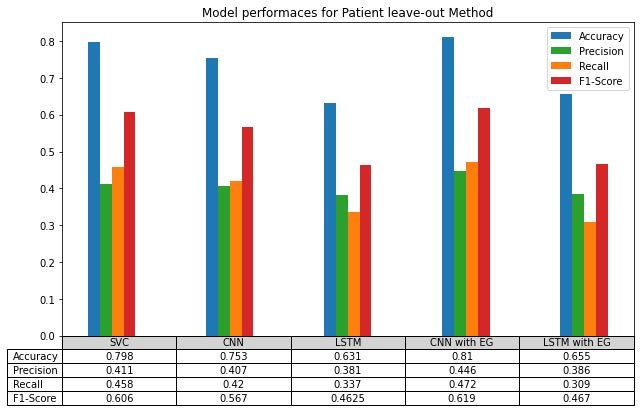

In [136]:
X = np.arange(len(r_name))
fig = plt.figure(figsize=(9,5))
# ax = fig.add_axes([0,0,1,1])
plt.bar(X - 0.15, r[0], color = 'tab:blue', width = 0.1)
plt.bar(X - 0.05, r[1], color = 'tab:green', width = 0.1)
plt.bar(X + 0.05, r[2], color = 'tab:orange', width = 0.1)
plt.bar(X + 0.15, r[3], color = 'tab:red', width = 0.1)
plt.legend(rows)
plt.xticks([])

# Add a table at the bottom of the axes
plt.table(cellText=r,
                      rowLabels=rows,
                      cellLoc='center',
                      # rowColours=['tab:blue', 'tab:green', 'tab:orange', 'tab:red'],
                      colLabels=r_name,
                      colColours=["lightgrey" for i in range(5)],
                      loc='bottom')
plt.tight_layout()
plt.subplots_adjust(bottom=0.1)
plt.title("Model performaces for Patient leave-out Method")
# plt.savefig("./images/pl_mp", dpi=300)
plt.show()
